# Electrical Failure Analysis

by [Prashant Brahmbhatt](https://www.github.com/hashbanger)

![Electrical](http://www.belyeapower.com/assets/templates/belyea/images/animation3.jpg)

_______

#### Importing libraries

In [134]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import warnings
warnings.filterwarnings('ignore')

In [135]:
sns.set_style('darkgrid')

Importing the dataset

In [155]:
data = pd.read_csv('electric_data.csv')
data.head()

,date_of_trip,time_of_trip,weather,other_circuit,line_trip,load_of_line,voltage,frequency,other_line_status,date of restoration,time_of_restoration,observation,repair_carried,tripping_reason,type_of_fault
0,08-11-2017,05:39,cloudy,healthy,yes,71,237,49.87,NaN,08-11-2017,07:50,NaN,nil,bad weather,low
1,10-05-2017,15:56,cloudy,healthy,yes,187,220,49.98,NaN,10-05-2017,16:34,NaN,nil,transient fault,high
2,11-10-2017,12:35,clear,healthy,yes,124,229,49.94,NaN,11-10-2017,13:45,NaN,nil,foreign element,medium
3,18-06-2017,05:37,clear,healthy,yes,105,228,50.01,NaN,18-06-2017,06:17,NaN,nil,foreign element,medium
4,19-06-2017,06:30,rainy,healthy,yes,102,229,50.05,NaN,19-06-2017,07:18,disc puncture,feeder isolated,transient fault,medium


In [156]:
print("The shape of the data is :",data.shape)

The shape of the data is : (38, 15)


In [157]:
data.describe()

,load_of_line,voltage,frequency,other_line_status
count,38.000000,38.000000,38.000000,0.0
mean,123.236842,231.000000,49.852632,NaN
std,46.066599,7.162213,0.991395,NaN
min,50.000000,218.000000,43.920000,NaN
25%,99.750000,225.250000,49.980000,NaN
50%,122.000000,230.000000,50.030000,NaN
75%,154.500000,236.000000,50.057500,NaN
max,230.000000,244.000000,50.160000,NaN


Our Target Class is the **type_of_fault**

## Handling Missing Values

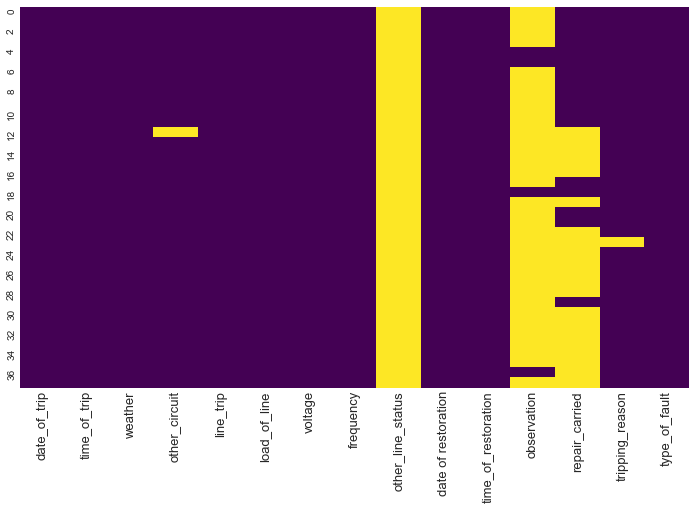

In [158]:
plt.figure(figsize=(12,7))
f = sns.heatmap(data.isnull(), cbar = False, cmap = 'viridis')
f.set_xticklabels(labels = f.get_xticklabels(), fontdict={'fontsize':13})
plt.show()

Observations:  
the columns **other_line_status** and **observation** are almost all missing so we can drop those.  
We will observe the significant missing values in column **repairs** before dropping.

There is a slight missing terms in the **tripping_reason** column.  
So we can fill it with the most frequent value

In [159]:
data['tripping_reason'].value_counts()

transient fault    11
bad weather        10
foreign element     4
fuse failure        3
trip from kite      2
breaker opened      2
earth fault         2
relay burn          2
wire fallen         1
Name: tripping_reason, dtype: int64

filling the missing value as ***transient_fault***

In [160]:
data['tripping_reason'].fillna(value = 'transient fault', inplace = True)

Another column having missing values is **other_circuit**

In [161]:
data['other_circuit'].value_counts()

healthy    37
Name: other_circuit, dtype: int64

Since we observe that the column contain only single and almost definitely occuring type of value so it is not suggestable to include this column having very less entropy, in the model

In [162]:
data.drop('other_line_status', inplace = True, axis  =1)
data.drop('observation', inplace = True, axis  =1)
data.drop('other_circuit', inplace = True, axis  =1)

Observing the missing values in **repairs_carried** column

In [163]:
data['repair_carried'].value_counts()

nil                    8
phase disc replaced    3
fuse                   2
leakage attended       2
relay removed          1
feeder isolated        1
Name: repair_carried, dtype: int64

filling it with most frequent value

In [164]:
data['repair_carried'].fillna(value = 'nil', inplace= True)

## EDA

Separating the **years**, **months** and **hours** from the date and time

In [165]:
#Separating year
data['trip_year'] = pd.to_datetime(data['date_of_trip'], dayfirst= True ).dt.year
data['restore_year'] = pd.to_datetime(data['date of restoration'], dayfirst= True ).dt.year

#Separating month
data['trip_month'] = pd.to_datetime(data['date_of_trip'], dayfirst= True ).dt.month
data['restore_month'] = pd.to_datetime(data['date of restoration'], dayfirst= True ).dt.month


#separating hours
data['trip_hour'] = pd.to_datetime(data['time_of_trip']).dt.hour
data['restore_hour'] = pd.to_datetime(data['time_of_restoration']).dt.hour

Mapping the integer **month** values to names

In [166]:
data.head(10)

,date_of_trip,time_of_trip,weather,line_trip,load_of_line,voltage,frequency,date of restoration,time_of_restoration,repair_carried,tripping_reason,type_of_fault,trip_year,restore_year,trip_month,restore_month,trip_hour,restore_hour
0,08-11-2017,05:39,cloudy,yes,71,237,49.87,08-11-2017,07:50,nil,bad weather,low,2017,2017,11,11,5,7
1,10-05-2017,15:56,cloudy,yes,187,220,49.98,10-05-2017,16:34,nil,transient fault,high,2017,2017,5,5,15,16
2,11-10-2017,12:35,clear,yes,124,229,49.94,11-10-2017,13:45,nil,foreign element,medium,2017,2017,10,10,12,13
3,18-06-2017,05:37,clear,yes,105,228,50.01,18-06-2017,06:17,nil,foreign element,medium,2017,2017,6,6,5,6
4,19-06-2017,06:30,rainy,yes,102,229,50.05,19-06-2017,07:18,feeder isolated,transient fault,medium,2017,2017,6,6,6,7
5,20-06-2017,17:04,cloudy,no,137,221,50.03,20-06-2017,17:10,relay removed,relay burn,medium,2017,2017,6,6,17,17
6,24-07-2017,11:32,cloudy,yes,173,220,49.98,24-07-2017,12:07,nil,transient fault,high,2017,2017,7,7,11,12
7,29-06-2017,13:51,cloudy,yes,180,227,50.03,29-06-2017,14:39,nil,foreign element,high,2017,2017,6,6,13,14
8,31-12-2017,07:38,foggy,yes,67,235,50.06,31-12-2017,09:26,nil,bad weather,low,2017,2017,12,12,7,9
9,11-06-2017,03:49,clear,no,146,232,50.01,11-06-2017,04:20,fuse,fuse failure,medium,2017,2017,6,6,3,4


In [168]:
data['trip_month'] = data['trip_month'].map({1:'January', 2:'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July',
                               8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})

data['restore_month'] = data['restore_month'].map({1:'January', 2:'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July',
                               8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})


Getting the weekdays from the date

In [172]:
data['weekday'] = pd.to_datetime(data['date_of_trip']).dt.weekday

Mapping the days number to names, where 0 maps to monday and so on

In [173]:
data['weekday'] = data['weekday'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

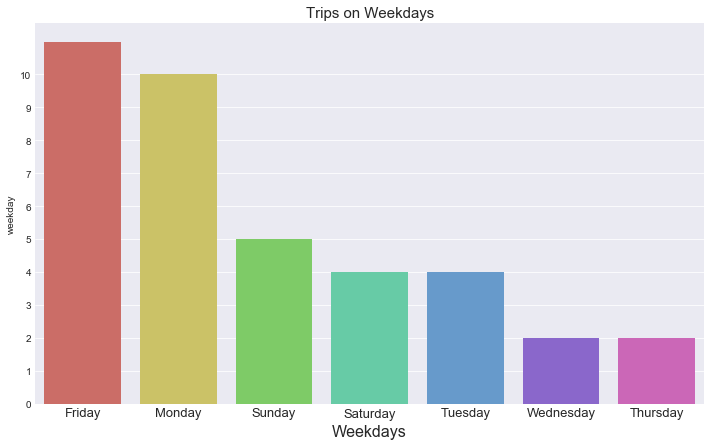

In [174]:
temp = data['weekday'].value_counts().reset_index()

plt.figure(figsize= (12,7))
plt.title('Trips on Weekdays',fontsize = 15)
f = sns.barplot(x = temp['index'], y = temp['weekday'], palette = 'hls')
f.set_xticklabels(labels = f.get_xticklabels(), fontdict={'fontsize':13})
plt.xlabel('Weekdays', fontsize = 16)
plt.yticks(list(range(max(temp['weekday']))))
plt.show()

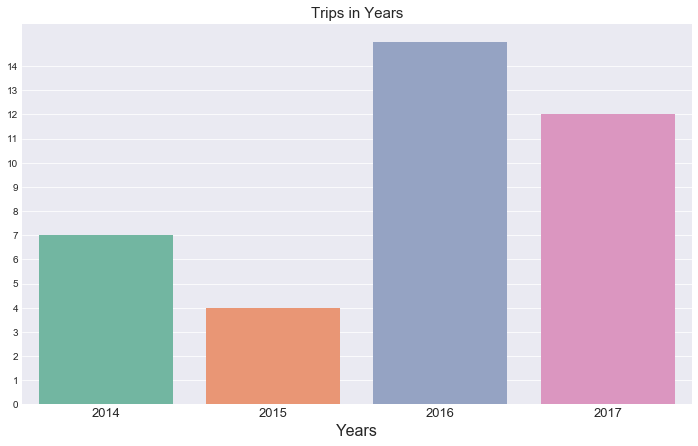

In [175]:
temp = data['trip_year'].value_counts()

plt.figure(figsize= (12,7))
plt.title('Trips in Years',fontsize = 15)
f = sns.barplot(x = temp.index, y = temp.values, palette = 'Set2')
f.set_xticklabels(labels = f.get_xticklabels(), fontdict={'fontsize':13})
plt.xlabel('Years', fontsize = 16)
plt.yticks(list(range(max(temp))))
plt.show()

Observation: (**Barplot**)    
We can see that year **2016** has most faults above all while 2015 has the least.

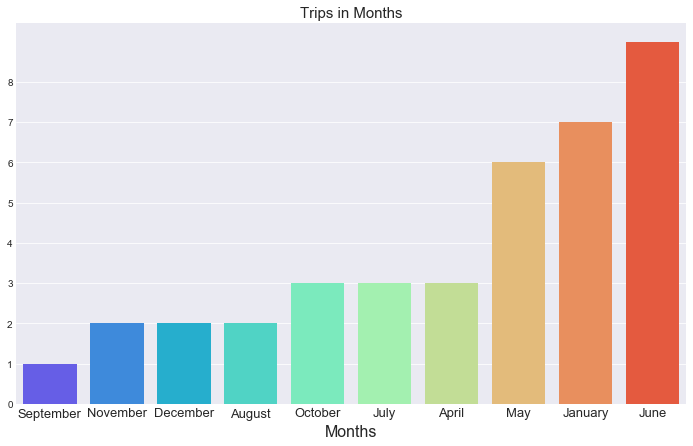

In [176]:
temp = data['trip_month'].value_counts()

plt.figure(figsize= (12,7))
plt.title('Trips in Months',fontsize = 15)
f = sns.barplot(x = temp.index[::-1], y = temp.values[::-1], palette = 'rainbow')
f.set_xticklabels(labels = f.get_xticklabels(), fontdict={'fontsize':13})
plt.xlabel('Months', fontsize = 16)
plt.yticks(list(range(max(temp))))
plt.show()

Observation: (**Barplot**)  
From the above plot we can observe that most number of faults are during Summer season and tens to happen less during the winter months.

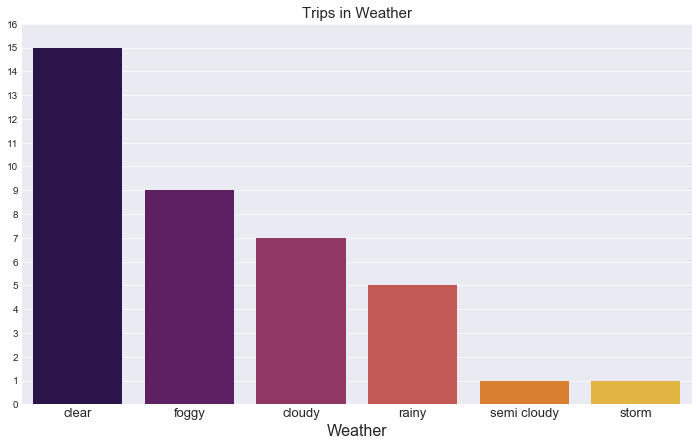

In [177]:
temp = data['weather'].value_counts()

plt.figure(figsize= (12,7))
plt.title('Trips in Weather',fontsize = 15)
f = sns.barplot(x = temp.index, y = temp.values, palette = 'inferno')
f.set_xticklabels(labels = f.get_xticklabels(), fontdict={'fontsize':13})
plt.xlabel('Weather', fontsize = 16)
plt.yticks(list(range(0,max(temp)+2)))
plt.show()

Observation: (**Barplot**)  
The faults are mostly during Clear skies.

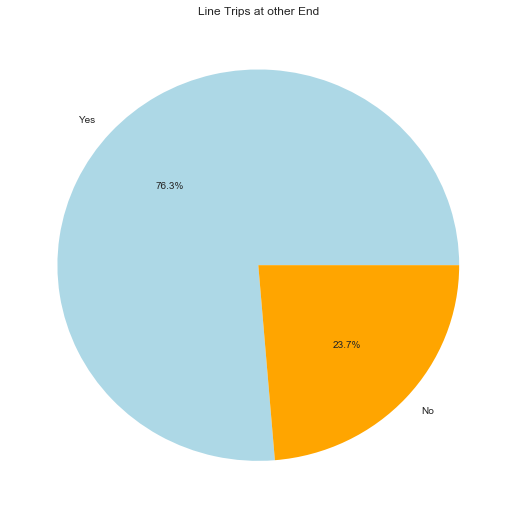

In [178]:
temp = data['line_trip'].value_counts().reset_index()

plt.figure(figsize=(9,9))
f = plt.pie(x = temp['line_trip'],labels = ['Yes','No'], colors=('lightblue','orange'), autopct= "%1.1f%%")
plt.title('Line Trips at other End')
plt.show()

Observation: (**Barplot**)  
Trips in the faults has been more than thrice than no trips.

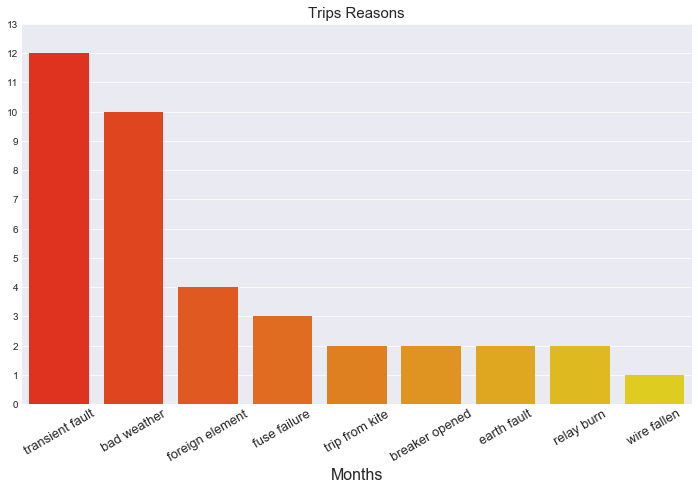

In [179]:
temp = data['tripping_reason'].value_counts()

plt.figure(figsize= (12,7))
plt.title('Trips Reasons',fontsize = 15)
f = sns.barplot(x = temp.index, y = temp.values, palette = 'autumn')
f.set_xticklabels(labels = f.get_xticklabels(), fontdict={'fontsize':13}, rotation = 30)
plt.xlabel('Months', fontsize = 16)
plt.yticks(range(max(temp)+2))
plt.show()

Observation: (**Barplot**)  
Among the faults reasons that most account of faults is due to **transient_fault** or **bad_weather**

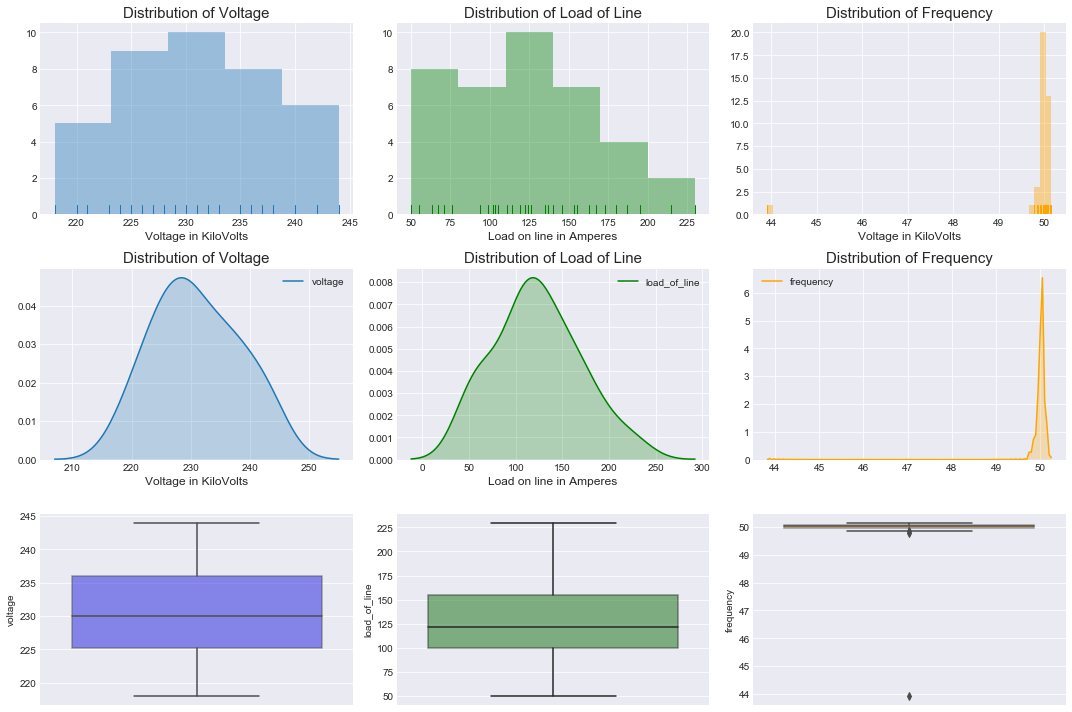

In [180]:
plt.figure(figsize= (15,10))
#plt.suptitle("Distributions of Different Features", fontsize = 20)
#Histograms
plt.subplot(3,3,1)
sns.distplot(data['voltage'], rug = True, kde = False)
plt.xlabel('Voltage in KiloVolts', fontsize = 12)
plt.title('Distribution of Voltage',fontsize = 15)

plt.subplot(3,3,2)
sns.distplot(data['load_of_line'], color= 'green',rug = True, kde = False)
plt.title('Distribution of Load of Line',fontsize = 15)
plt.xlabel('Load on line in Amperes', fontsize = 12)

plt.subplot(3,3,3)
sns.distplot(data['frequency'], rug= True, color= 'orange', kde = False)
plt.xlabel('Voltage in KiloVolts', fontsize = 12)
plt.title('Distribution of Frequency',fontsize = 15)


#Kde Plots
plt.subplot(3,3,4)
sns.kdeplot(data['voltage'], shade = True)
plt.xlabel('Voltage in KiloVolts', fontsize = 12)
plt.title('Distribution of Voltage',fontsize = 15)

plt.subplot(3,3,5)
sns.kdeplot(data['load_of_line'], shade = True, color = 'g')
plt.title('Distribution of Load of Line',fontsize = 15)
plt.xlabel('Load on line in Amperes', fontsize = 12)

plt.subplot(3,3,6)
sns.kdeplot(data['frequency'],shade= True, color = 'Orange')
plt.title('Distribution of Frequency',fontsize = 15)

#Box Plots
plt.subplot(3,3,7)
sns.boxplot(x = data['voltage'], orient = 'v',color= 'b', boxprops=dict(alpha=.5))
plt.subplot(3,3,8)
sns.boxplot(x = data['load_of_line'], orient = 'v', color= 'g', boxprops=dict(alpha=.5))
plt.subplot(3,3,9)
sns.boxplot(x = data['frequency'], orient = 'v', color= 'Orange', boxprops=dict(alpha=.5))

plt.tight_layout()
plt.show()

Observation: (**Histogram, Kernel Plot and Box Plot**)  
 
We can see that **Voltage** and **Current** have considerable spread however there is very little spread in the **frequency** parameter.  
Since it is not entirely fixed rather than dropping it we can scale it for the model.  
There is not a sufficient amount of data to have some outliers either.

### Versus Plots

#### Voltage vs load_of_line

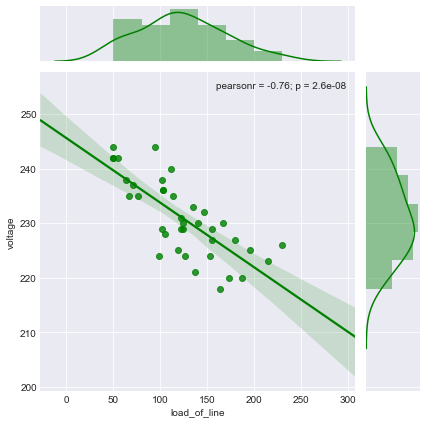

In [181]:
sns.jointplot(x = data['load_of_line'], y = data['voltage'], kind = 'reg', color= 'g')
plt.show()

#### load_of_line vs frequency

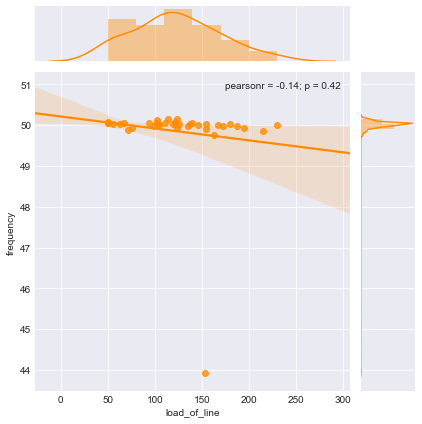

In [182]:
sns.jointplot(x = data['load_of_line'], y = data['frequency'], kind = 'reg', color= 'darkorange')
plt.show()

#### voltage vs frequency

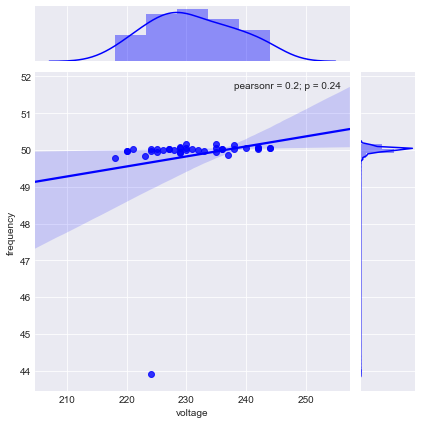

In [183]:
sns.jointplot(x = data['voltage'], y = data['frequency'], kind = 'reg', color = 'blue')
plt.show()

Observation: (**Joint Plots**)  
1. **Voltage vs load_of_line** shows a sufficiently strong negative correlation of -0.76.  
    So we might consider dropping the voltage parameter since the dataset is not very large and we want to reduce any multicollinearlity also  
    as per Occam's Razor principle we will drop it if the accuracy is not drastically effected.  
2. **load_of_line vs frequency** does not have any significant relationship.  
3. same goes for **voltage vs frequency**.  

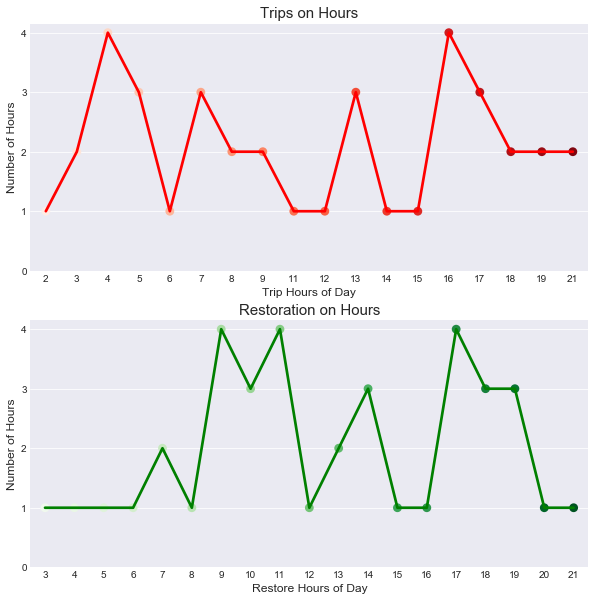

In [184]:
temp = data['trip_hour'].value_counts()
plt.figure(figsize= (10,10))

plt.subplot(2,1,1)
sns.pointplot(x = temp.index, y = temp.values ,palette= 'Reds')
sns.pointplot(x = temp.index, y = temp.values ,join= True, color = 'r',markers = '')
plt.title('Trips on Hours',fontsize = 15)
plt.xlabel('Trip Hours of Day', fontsize = 12)
plt.ylabel('Number of Hours', fontsize = 12)
plt.yticks([0,1,2,3,4])

temp = data['restore_hour'].value_counts()
plt.subplot(2,1,2)
sns.pointplot(x = temp.index, y = temp.values ,palette= 'Greens')
sns.pointplot(x = temp.index, y = temp.values ,join= True, color='g', markers = '')
plt.title('Restoration on Hours',fontsize = 15)
plt.xlabel('Restore Hours of Day', fontsize = 12)
plt.ylabel('Number of Hours', fontsize = 12)
plt.yticks([0,1,2,3,4])
plt.show()

Observation: (**Line Plot**)  
We can observe that the most fault peaks (plot 1 in red), has highest peaks during the very early morning and during dusk.  
There is not sufficient regular pattern so it may or may not be a considerable parameter.

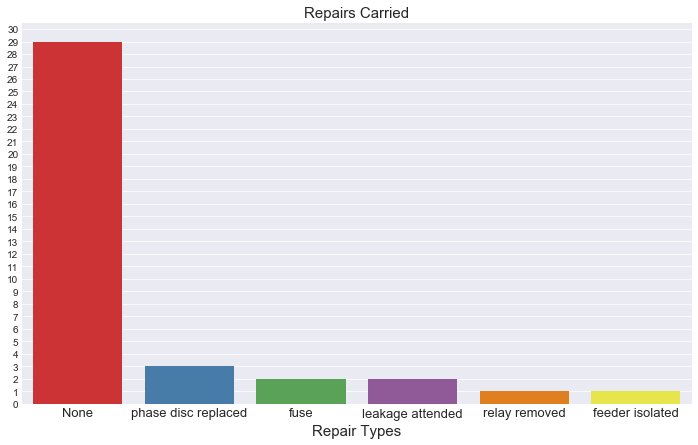

In [186]:
for i in range(0,len(data['repair_carried'])):
    if data['repair_carried'][i] == 'nil':
        data['repair_carried'][i] = 'None'
temp = data['repair_carried'].value_counts()
plt.figure(figsize= (12,7))
plt.title('Repairs Carried',fontsize = 15)
f = sns.barplot(x = temp.index, y = temp.values, palette = 'Set1')
f.set_xticklabels(labels = f.get_xticklabels(), fontdict={'fontsize':13})
plt.xlabel('Repair Types', fontsize = 15)
plt.yticks(range(max(temp)+2))
plt.show()

Mostly there were no repairs were done or maybe not recorded and if there are no faults then the repairs would be **None** for them too. So we can rule this out as a prarmeter

### Mapping the **line_trip** feature

Converting the **line_trip** feature from categorical to numeric

In [187]:
data['line_trip'] = data['line_trip'].map({'no':0, 'yes':1})

### Mapping the Target Class

Mapping the **type_of_fault** to integer values signified by:  
**-1** - Low Fault  
**0** - Medium Fault  
**1** - High Fault

In [188]:
data['type_of_fault'] = data['type_of_fault'].map({'low':-1, 'medium':0, 'high': 1})

Finally the data look as below

In [189]:
data.head()

,date_of_trip,time_of_trip,weather,line_trip,load_of_line,voltage,frequency,date of restoration,time_of_restoration,repair_carried,tripping_reason,type_of_fault,trip_year,restore_year,trip_month,restore_month,trip_hour,restore_hour,weekday
0,08-11-2017,05:39,cloudy,1,71,237,49.87,08-11-2017,07:50,None,bad weather,-1,2017,2017,November,November,5,7,Friday
1,10-05-2017,15:56,cloudy,1,187,220,49.98,10-05-2017,16:34,None,transient fault,1,2017,2017,May,May,15,16,Thursday
2,11-10-2017,12:35,clear,1,124,229,49.94,11-10-2017,13:45,None,foreign element,0,2017,2017,October,October,12,13,Friday
3,18-06-2017,05:37,clear,1,105,228,50.01,18-06-2017,06:17,None,foreign element,0,2017,2017,June,June,5,6,Sunday
4,19-06-2017,06:30,rainy,1,102,229,50.05,19-06-2017,07:18,feeder isolated,transient fault,0,2017,2017,June,June,6,7,Monday


Due to small size of data choosing lot of features will increase the chances of overfitting and since lack of sufficient evidence in many fatures we will limit our feature list to **line_trip**, **load_of_line** and **frequency**

## Predictive Modelling

### Scaling the features

As we have previously observed **frequency** needs to be scaled and so do the **load_of_line** parameter

Using **Standardization Equation** for scaling  
![sc](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2015/09/24071007/Z-score-form.png)

### Using KNeighborsClassifier

In [190]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = data.iloc[:, [3,4,6]] #Choosing Current, Voltage and Frequency
sc.fit(X_train)
X_train = sc.transform(X_train)
y_train = data['type_of_fault']

In [191]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_train)


In [192]:
from sklearn.metrics import classification_report
cr1 = classification_report(y_train, y_pred)
print(cr1)

             precision    recall  f1-score   support

         -1       1.00      0.80      0.89        10
          0       0.81      1.00      0.89        17
          1       1.00      0.82      0.90        11

avg / total       0.91      0.89      0.89        38



In [193]:
t = input("Enter Trip\t")
l = float(input("Enter load of line\t"))
f = float(input("Enter Frequency\t"))

if t =='yes':
    t = 1
elif t == 'no':
    t = 0
    
samp = np.array([[int(t), int(l), float(f)]])
samp = sc.transform(samp)
res = classifier.predict(samp)
print("\n------Output-----\n")
if res == -1:
    print("Low Fault")
elif res == 0:
    print("Medium Fault")
else:
    print("High Fault")

Enter Trip	yes
Enter load of line	123
Enter Frequency	50

------Output-----

Medium Fault


### Using Multinomial Logistic Regression

In [194]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = data.iloc[:, [3,4,6]] #Choosing Current, Voltage and Frequency
sc.fit(X_train)
X_train = sc.transform(X_train)
y_train = data['type_of_fault']

In [195]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver= 'newton-cg',multi_class= 'multinomial')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_train)

In [196]:
from sklearn.metrics import classification_report
cr1 = classification_report(y_train, y_pred)
print(cr1)

             precision    recall  f1-score   support

         -1       1.00      0.80      0.89        10
          0       0.89      1.00      0.94        17
          1       1.00      1.00      1.00        11

avg / total       0.95      0.95      0.95        38



In [197]:
t = input("Enter Trip\t")
l = float(input("Enter load of line\t"))
f = float(input("Enter Frequency\t"))

if t =='yes':
    t = 1
elif t == 'no':
    t = 0
    
samp = np.array([[int(t), int(l), float(f)]])
samp = sc.transform(samp)
res = classifier.predict(samp)
print("\n------Output-----\n")
if res == -1:
    print("Low Fault")
elif res == 0:
    print("Medium Fault")
else:
    print("High Fault")

Enter Trip	yes
Enter load of line	123
Enter Frequency	50

------Output-----

Medium Fault


#### voila!